In [1]:
import anndata as ad  
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import pcdl

### Load data

In [2]:
dir_output = "../output/"
config_file = "../config/NLC_CLL.xml"
mcdsts = pcdl.TimeSeries(dir_output, settingxml=config_file, verbose = False, microenv=False, graph=False) 
timesteps = mcdsts.get_mcds_list()

In [12]:
from collect_data import collect_data
dir_output = "../output/"
config_file = "../config/NLC_CLL.xml"
res = collect_data(dir_output, config_file)
res[0]

0     95.505618
1     94.146949
2     90.260631
3     93.233674
4     91.954023
5     91.683168
6     92.375691
7     93.341554
8     93.561644
9     95.045045
10    95.106036
11    97.142857
12    98.797251
13    99.307958
Name: CLL viability, dtype: float64

#### Extract positions corresponding to days 1-13

In [32]:
positions = []
for days in range(0,14):
    hours = 24*days
    positions.append(hours)

#Extract day 0
initial = timesteps[0].get_cell_df(states=1)

#### Extract cell type counts across days

##### CLL cells

In [33]:
#Initial CLL cells
alive_initial = len(initial[(initial['cell_type']=="cancer")])
apoptotic_initial = len(initial[(initial['cell_type']=="apoptotic")])
dead_initial = len(initial[(initial['cell_type']=="dead")])

CLL_initial = alive_initial + apoptotic_initial + dead_initial
    
alive = [alive_initial]
dead = [dead_initial]
apoptotic = [apoptotic_initial]

for i in range(1, len(positions)):
    step = timesteps[positions[i]].get_cell_df(states=1)
    number_alive = len(step[(step['cell_type']=='cancer')&(step['dead']==False)]) #step['dead'] is only a formality cause all cells are considered 'alive', 'dead' is another celltype for this model
    number_apoptotic = len(step[(step['cell_type']=='apoptotic')&(step['dead']==False)])
    number_dead = len(step[(step['cell_type']=='dead')&(step['dead']==False)])
    alive.append(number_alive)
    dead.append(number_dead)
    apoptotic.append(number_apoptotic)

CLL_alive = pd.Series(alive, name="Cells_alive")
CLL_apoptotic = pd.Series(apoptotic, name = "Cells_apoptotic")
CLL_dead = pd.Series(dead, name = "Cells_dead")

#### CLL viability and concentration

In [34]:
#viability at time t =  CLL alive at time t / (CLL alive + CLL apoptotic + CLL dead) at time t
viability = []
for i in range(len(CLL_alive)):
    number = (CLL_alive[i] / (CLL_alive[i] + CLL_apoptotic[i] + CLL_dead[i])) * 100
    viability.append(number)

viability = pd.Series(viability, name = "CLL viability")

#concentration at time t =  CLL cells at time t / (CLL initial)
concentration = []
for i in range(len(CLL_alive)):
    number = ((CLL_alive[i] + CLL_apoptotic[i] + CLL_dead[i])/CLL_initial)*100
    concentration.append(number)

concentration = pd.Series(concentration, name = "CLL concentration")

#### CLL survival plots

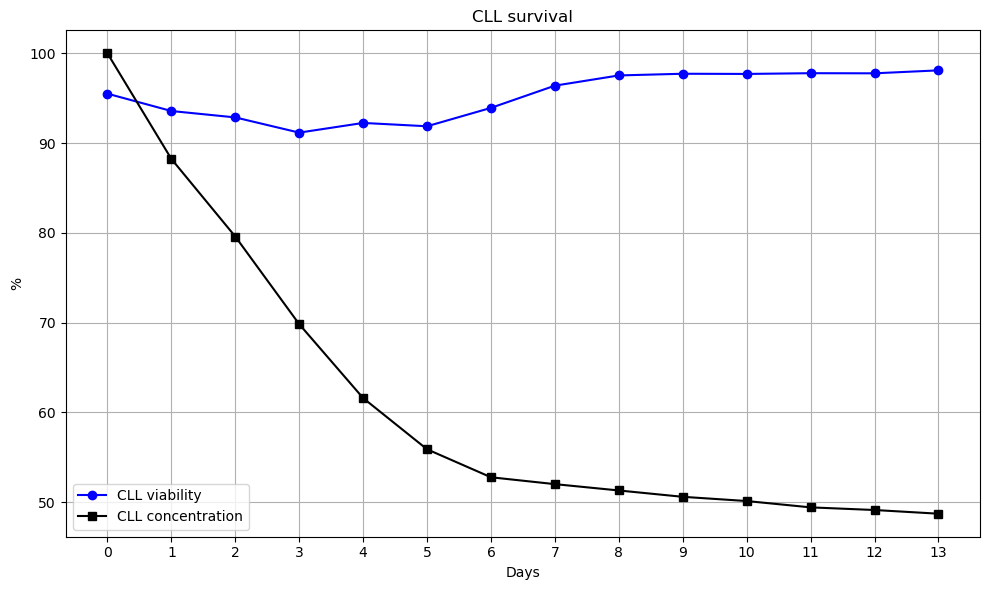

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

time_points = np.arange(0, 14)  # Days (1 to 14)

plt.figure(figsize=(10, 6))

plt.plot(time_points, viability, label=viability.name, color='blue', marker='o')
plt.plot(time_points, concentration, label=concentration.name, color='black', marker='s')

plt.xticks(np.arange(0, 14, 1))

plt.xlabel("Days")
plt.ylabel("%")
plt.title("CLL survival")
plt.legend()

plt.grid(True)  
plt.tight_layout()  
plt.show()

##### Myeloid cells

In [36]:
#Initial myeloid cells
monocytes_initial = len(initial[(initial['cell_type']=="monocytes")])
macrophages_initial = len(initial[(initial['cell_type']=="macrophages")])
nlc_initial = len(initial[(initial['cell_type']=="NLCs")])

monocytes = [monocytes_initial]
macrophages = [macrophages_initial]
nlc = [nlc_initial]

for i in range(1, len(positions)):
    step = timesteps[positions[i]].get_cell_df(states=1)
    number_monocytes = len(step[(step['cell_type']=='monocytes')]) #step['dead'] is only a formality cause all cells are considered 'alive', 'dead' is another celltype for this model
    number_macrophages = len(step[(step['cell_type']=='macrophages')])
    number_nlc = len(step[(step['cell_type']=='NLCs')])
    monocytes.append(number_monocytes)
    macrophages.append(number_macrophages)
    nlc.append(number_nlc)

Monocytes = pd.Series(monocytes, name="Monocytes")
Macrophages = pd.Series(macrophages, name = "Macrophages")
NLCs = pd.Series(nlc, name = "NLCs")

#### Cell population plot

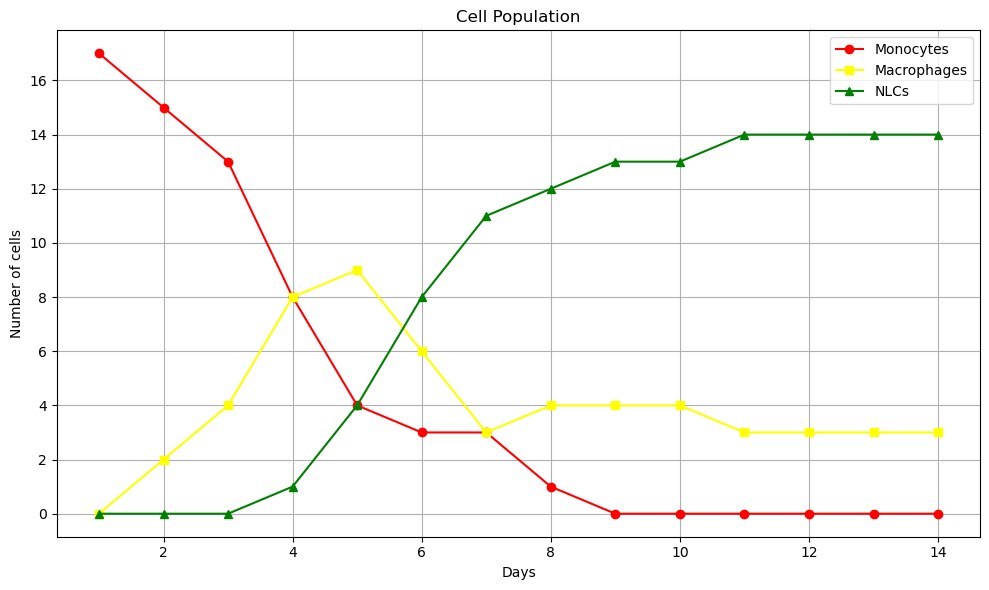

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

time_points = np.arange(1, 15)  # Days (1 to 14)

plt.figure(figsize=(10, 6))

plt.plot(time_points, Monocytes, label=Monocytes.name, color='red', marker='o')
plt.plot(time_points, Macrophages, label=Macrophages.name, color='yellow', marker='s')
plt.plot(time_points, NLCs, label=NLCs.name, color='green', marker='^')

plt.yticks(np.arange(0, 18, 2))

plt.xlabel("Days")
plt.ylabel("Number of cells")
plt.title("Cell Population")
plt.legend()

plt.grid(True)  
plt.tight_layout()  
plt.show()


#### Results analysis after iterations

In [71]:
viability = pd.read_csv('../data/Viability_results.csv', delimiter=",")
concentration = pd.read_csv('../data/Concentration_results.csv', delimiter=",")

monocytes = pd.read_csv('../data/Monocytes_results.csv', delimiter=",")
macrophages = pd.read_csv('../data/Macrophages_results.csv', delimiter=",")
nlcs = pd.read_csv('../data/NLCs_results.csv', delimiter=",")

##### CLL survival

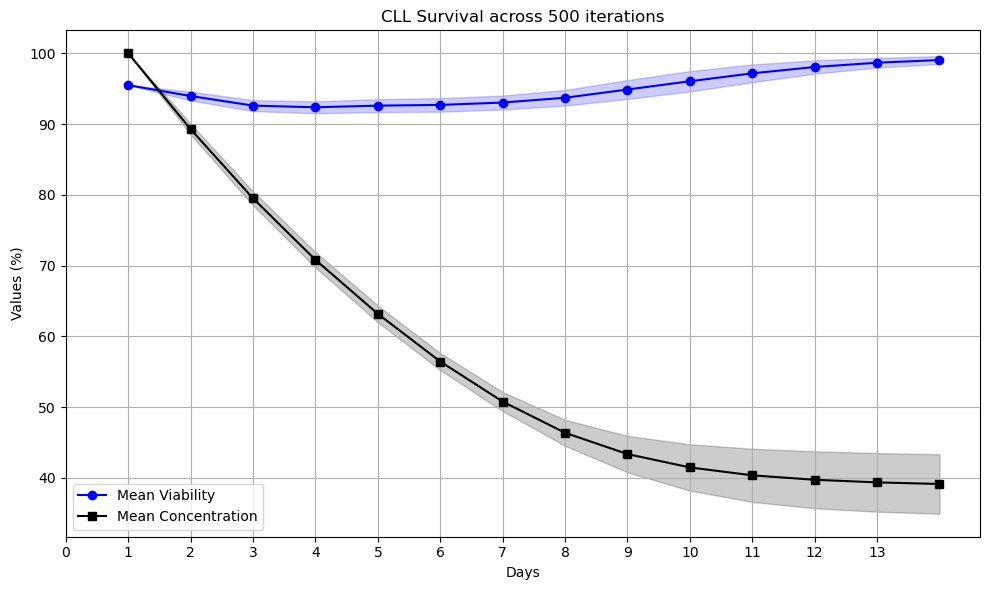

In [72]:
# Calculate mean and standard deviation across simulations
viability_mean = viability.mean(axis=1)
viability_std = viability.std(axis=1)

concentration_mean = concentration.mean(axis=1)
concentration_std = concentration.std(axis=1)

plt.figure(figsize=(10, 6))

# Plot viability with its shaded region
plt.plot(time_points, viability_mean, label='Mean Viability', color='blue', marker='o')
plt.fill_between(
    time_points,
    viability_mean - viability_std,
    viability_mean + viability_std,
    color='blue',
    alpha=0.2
)

# Plot concentration with its shaded region
plt.plot(time_points, concentration_mean, label='Mean Concentration', color='black', marker='s')
plt.fill_between(
    time_points,
    concentration_mean - concentration_std,
    concentration_mean + concentration_std,
    color='black',
    alpha=0.2
)

# Customize plot
plt.xticks(np.arange(0, 14, 1))
plt.xlabel("Days")
plt.ylabel("Values (%)")
plt.title("CLL Survival across " + str(len(viability.iloc[1])) + " iterations")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


##### Cell population 

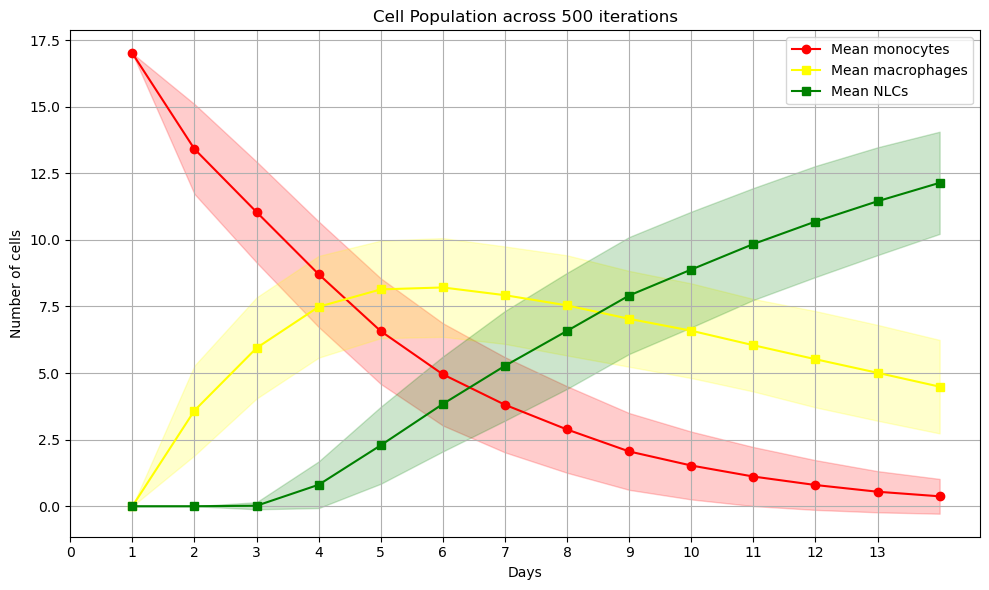

In [74]:
# Calculate mean and standard deviation across simulations
monocytes_mean = monocytes.mean(axis=1)
monocytes_std = monocytes.std(axis=1)

macrophages_mean = macrophages.mean(axis=1)
macrophages_std = macrophages.std(axis=1)

nlcs_mean = nlcs.mean(axis=1)
nlcs_std = nlcs.std(axis=1)

plt.figure(figsize=(10, 6))

# Plot viability with its shaded region
plt.plot(time_points, monocytes_mean, label='Mean monocytes', color='red', marker='o')
plt.fill_between(
    time_points,
    monocytes_mean - monocytes_std,
    monocytes_mean + monocytes_std,
    color='red',
    alpha=0.2
)

# Plot concentration with its shaded region
plt.plot(time_points, macrophages_mean, label='Mean macrophages', color='yellow', marker='s')
plt.fill_between(
    time_points,
    macrophages_mean - macrophages_std,
    macrophages_mean + macrophages_std,
    color='yellow',
    alpha=0.2
)

# Plot concentration with its shaded region
plt.plot(time_points, nlcs_mean, label='Mean NLCs', color='green', marker='s')
plt.fill_between(
    time_points,
    nlcs_mean - nlcs_std,
    nlcs_mean + nlcs_std,
    color='green',
    alpha=0.2
)

# Customize plot
plt.xticks(np.arange(0, 14, 1))
plt.xlabel("Days")
plt.ylabel("Number of cells")
plt.title("Cell Population across " + str(len(viability.iloc[1])) + " iterations")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()